### John Leeds

### Project 09

# Typing Speed Analysis

In this project, I be analyzing data about my typing speed scraped from [play.typeracer.com.](https://play.typeracer.com)  I will be exploring different ways of predicting my typing speed as well as how I can improve my typing speed.

In [1]:
import requests
from bs4 import BeautifulSoup # requests / bs4 used for scraping play.typeracer.com
import json # cache my scraping results
import time # I can only make 30 requests per minute so I need to sleep between requests
import csv # save processed data to avoid repeat processing

# Question 1) Is it possible to predict how fast I will type a text?

Given a text, I want to see if I can predict how fast I will type it.

In order to predict how fast I would type a text, I will compare multiple machine learning models as well as a simpler model that tracks my average speed for every bigram (more details later).

## Gathering data

I need a lot of data in order to create a model to predict my typing speed, but luckily there is a lot of data on TypeRacer.  Unfortunately, scraping results from TypeRacer is difficult.  A result is given in the form of a string of each character followed by the number of milliseconds it took to type it.  For example, the string "t53h26e10 90" means that I took 53 ms to type t, 26 ms to type h, etc.  This might seem simple enough, but it gets complicated when there are numbers in the text.  I've also come to the conclusion that their system for saving results is buggy.  I used lots of trial and error to correct strange logs - the code is not pretty but it works well enough.

You can see an example of a typing log [here.](https://data.typeracer.com/pit/result?id=|tr:nothisisjohn|15812) (find the text and log by viewing the page source and doing ctrl + f and searching for "var typingLog")

I examined the Type Racer client-side code for a long time to see if I could figure out how they are parsing their race logs (or if I could find their parsed race logs), but was not able to find anything.  This process was made more difficult by their obfuscation and minification.

In [2]:
# Because I am scraping thousands of race results, it is important for me to cache my results.
with open("data.json", "r") as f:
    cache = json.load(f)

# I also am tracking errors where my parser doesn't work so I can examine them later.
with open("errors.json", "r") as f:
    errors = json.load(f)

In [65]:
# This function makes a request to TypeRacer and saves the relevant information
def get_race(username, race_num, add_to_cache=True):
    username = username.lower()
    # turn into string because I couldn't use json dumps on a tuple
    key = f"{username}|{race_num}"
    try:
        if key in cache:
            return "cached"
        url = f"https://data.typeracer.com/pit/result?id=|tr:{username}|{race_num}"
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        # Some texts have two spaces - ex: https://data.typeracer.com/pit/result?id=|tr:nothisisjohn|15024
        text = soup.find("div", class_="fullTextStr").text.strip().replace("  ", " ")
        text = text.replace("\t", " ")
        text = text.replace("\n", " ")
        text = text.replace("\r", " ")
        text = text.replace("  ", " ") # this is lazy but works
        text = text.replace('\\"', '"')
        text = text.replace("  ", " ")
        log = soup.find_all("script", type="text/javascript")[1].text.strip()
        log = log[log.find("TLv1,en,") + len("TLv1,en,"):log.find("|")]
        log = log[log.find(text[0]):]
        log = log.replace('\\"', '"')
        log = log.replace("  ", " ")
        if add_to_cache:
            cache[key] = {"text": text, "log": log}
        return "good"
    except:
        print(f"Error with {key}")
        if add_to_cache:
            errors[key] = True
        return "error"

After creating a function to add an individual race to my cache, I can simply loop over the index of every race I want to download.  However, I can only make 30 requests / minute so I have to use `time.sleep()` to sleep between requests. I am also saving my logs after every 50 races to avoid losing lots of progress if something crashes.

In [4]:
def get_races(username, start_race, end_race):
    for race_num in range(start_race, end_race + 1):
        start_time = time.time()
        res = get_race(username, race_num)
        # I can make 30 requests / minute
        if res != "cached":
            time.sleep(max(start_time + 2.15 - time.time(), 0))
        if race_num % 50 == 0: # save every 50 races in case something happens
            print(f"{race_num}")
            save()
            
    save()
    
def save():
    with open("data.json", "w") as f:
        json.dump(cache, f)
    
    with open("errors.json", "w") as f:
        json.dump(errors, f)

If you would like to download your own data from TypeRacer, delete the data.json and errors.json files, and call `get_races(username, start_race, end_race)` with your own information.  I would recommend using at least 1,000 races.

In [5]:
get_races("nothisisjohn", 14000, 15812)

14000
14050
14100
14150
14200
14250
14300
14350
14400
14450
14500
14550
14600
14650
14700
14750
14800
14850
14900
14950
15000
15050
15100
15150
15200
15250
15300
15350
15400
15450
15500
15550
15600
15650
15700
15750
15800


## Data Wrangling

Like I mentioned earlier, the developers of TypeRacer did not make this easy.  I began wrangling my data by changing the raw typing logs to something more manageable.  I created a list of tuples with the character typed and the number of ms it took to type it.

In [6]:
def parse_log(log, text):
    ESCAPE_CHAR = chr(999)
    text = text.replace("\t", " ") # more lazy replaces to deal with oddities in logs
    text = text.replace("  ", " ")
    log = log.replace("\\b", ESCAPE_CHAR)
    log = log.replace('\\"', '"')
    indices = [] # create a list of the indices of the actual characters in the text
    # for example, if the first three letters of a text are "Bea" and the log starts with
    # "B232e116a30", I want to mark that the B starts at index 0, e starts at 4, a starts at 8 etc.
    log_i = 0
    for c in text:
        if c.isnumeric():
            indices.append(log.find(f"{ESCAPE_CHAR}{c}", log_i) + 1)
        else:
            indices.append(log.find(c, log_i))
        log_i = indices[-1] + 1
    
    # using my list of start positions for each character, I can look ahead and grab the number
    # following the start position. I use two passes over each log to make parsing numbers
    # easier. This way, I can tell when a digit is a digit that is in the text or included
    # in the number of ms it took to type a character.
    parsed_log = []
    for i, log_i in enumerate(indices):
        if i + 1 == len(indices):
            parsed_log.append((log[log_i], int(log[indices[-1] + 1:])))
            continue
        num = []
        for j in range(log_i + 1, len(log)):
            if not log[j].isnumeric():
                break
            num.append(log[j])
        parsed_log.append((log[log_i], int("".join(num))))
    return parsed_log

After creating a log of each race, I need to assemble a dataframe.  However, I'm initally just creating a CSV that I can load as a dataframe so I don't need to do this processing every time. Each row contains the 4 characters leading up to the character I am about to type and the 3 characters following it and the time it took to type that character.  My theory is that if I am typing the character "x", the characters I type before and after will effect how fast I type "x."  For example, if I type "x" with my index finger and I type the character before it with my index finger, it could take me longer to move my index finger from "y" to "x."

In [7]:
# the first character and last characters don't have characters preceding / following them
# so I am adding in a character to represent this.
BLANK_CHAR = chr(1000)
def get_log_rows(text, log=None):
    if log is not None:
        parsed_log = parse_log(log, text)
    res = []
    text = text.replace("  ", " ") # sometimes there are two spaces where there should be one :(
    for i, c in enumerate(text):
        res.append([])
        for l in range(i - 4, i):
            if l < 0:
                res[-1].append(BLANK_CHAR)
            else:
                res[-1].append(text[l])
        res[-1].append(c)
        for r in range(i + 1, i + 4):
            if r >= len(text):
                res[-1].append(BLANK_CHAR)
            else:
                res[-1].append(text[r])
        if log is not None:
            res[-1].append(parsed_log[i][1])
    return res

Save my csv so I can later load it as a dataframe.

In [8]:
rows = []
for race in cache.values():
    try:
        rows.extend(get_log_rows(race["text"], race["log"]))
    except: # there are very few errors (maybe a few per thousand) so I'm just ignoring them.
        continue

with open("data.csv", "w") as f:
    fieldnames = list(range(-4, 4)) + ["ms"]
    writer = csv.writer(f)
    writer.writerow(fieldnames)
    writer.writerows(rows)

## Making the Models

Now that I have a good dataset, I can create my models for predicting typing speed.

Using the Scikit-learn article on [choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), I am first going to use a SGDRegressor.  I am predicting a quantity (milliseconds it takes to type a character) and have well over 100k samples.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

In [66]:
df = pd.read_csv("data.csv")
print(df.shape) # 500,000 rows, one row per character typed
df.head()

(511045, 9)


,-4,-3,-2,-1,0,1,2,3,ms
0,Ϩ,Ϩ,Ϩ,Ϩ,I,,f,i,255
1,Ϩ,Ϩ,Ϩ,I,,f,i,n,72
2,Ϩ,Ϩ,I,,f,i,n,d,44
3,Ϩ,I,,f,i,n,d,,86
4,I,,f,i,n,d,,i,53


There are a few characters that don't appear very often (for example, there aren't very many texts with a % sign).  If I haven't typed a character at least 25 times, I am going to replace it with a character to represent all rare characters.  This will later reduce the number of columns in my dataframe.

In [11]:
character_counts = {} # create dictionary of how many times each character appears
for _, row in df.iterrows():
    c = row['0']
    if c in character_counts:
        character_counts[c] += 1
    else:
        character_counts[c] = 1
        
character_counts[BLANK_CHAR] = 100000

In [12]:
RARE_CHAR = chr(1001)

# replace all rare characters
replace_chars = [c for c, num_typed in character_counts.items() if num_typed < 25]
df = df.replace(replace_chars, RARE_CHAR)

It is difficult to encode the data in a way that I can pass it to the model (see below).  So, unfortunately I'll have to base my model on the 2 characters preceding the character I am about to type and one character after it.  However, I have a feeling this might actually be a good thing because I don't know if the character typed 4 characters before will have a statistically significant effect on how fast I type a character.

In [13]:
df = df.drop(["-4", "-3", "2", "3"], axis=1)
df.head()

,-2,-1,0,1,ms
0,Ϩ,Ϩ,I,,255
1,Ϩ,I,,f,72
2,I,,f,i,44
3,,f,i,n,86
4,f,i,n,d,53


Because this is unordered categorical data, I am using [one hot encoding.](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) After encoding the data, I am getting the X and y columns.  The X columns will be the characters and the y column (my prediction) is the number of milliseconds.

In [14]:
y = df["ms"]

X_labels = [str(n) for n in range(-2, 2)]
X = pd.get_dummies(df, columns=X_labels).drop(["ms"], axis=1)
# sort the column names because I have to have a consistent order when passing in
# a dataframe to predict
X = X.reindex(sorted(X.columns), axis=1)
X.head()

,-1_,-1_!,"-1_""",-1_',-1_(,-1_),"-1_,",-1_-,-1_.,-1_0,...,1_s,1_t,1_u,1_v,1_w,1_x,1_y,1_z,1_Ϩ,1_ϩ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, I can train my model and evaluate it.

In [15]:
# split into train / test data so I can evalutae my model.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.9)
# without setting the max_iter, I got a warning suggesting to use a larger value for max_iter
sgd = SGDRegressor(max_iter=2000)
sgd.fit(X_train, y_train)

SGDRegressor(max_iter=2000)

In [16]:
print(f"Average ms per character: {y_test.mean():.2f}")
y_pred = sgd.predict(X_test)
print(f"Mean absolute error: {mean_absolute_error(y_pred, y_test):.2f}")

Average ms per character: 72.95
Mean absolute error: 26.26


On average, this model is 26 ms off of my true typing speed per character. This seems quite high, but I am guessing that this can be explained by the fact that when I make a typo, it takes me a lot longer to type that character which will increase the mean absolute error.

Next, I want to try using a Decision Tree Regressor.  Scikit-learn makes swapping models very easy.

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [18]:
y_pred = tree.predict(X_test)
print(f"Mean absolute error: {mean_absolute_error(y_pred, y_test):.2f}")

Mean absolute error: 23.48


It seems like this model is performing slightly better, with a mean absolute error of 23 ms compared to 26 ms.

Finally, I want to try creating my own model to predict typing speed rather than using a machine learning model from scikit-learn.  In order to do this, I will assemble a dictionary of every bigram (two consecutive letters) and get the average speed at which I type the second character.  If I have not typed that bigram enough times to have a meaningful amount of data, I will just use the average speed that I type that character.  I will handle rare characters in a similar way by grouping them all together.

In [67]:
# create dictionary of bigrams and the average time it took me to type that character
# I will also treat the first character per text as a special case because it is 
# more about your reaction time (and lag) than actual typing speed.
df = pd.read_csv("data.csv")

typing_speeds = {"first_char": [0, 0], "total_no_starting_chars": [0, 0]} # character: total ms, times seen
for _, row in df.iterrows():
    if row['-1'] == BLANK_CHAR: # first character in text
        typing_speeds["first_char"][0] += row['ms']
        typing_speeds["first_char"][1] += 1
        continue
    bigram = row['-1'] + row['0'] # save bigram information
    if bigram in typing_speeds:
        typing_speeds[bigram][0] += row['ms']
        typing_speeds[bigram][1] += 1
    else:
        typing_speeds[bigram] = [row['ms'], 1]
    
    ch = row['0'] 
    if ch in typing_speeds: # get individual character information
        typing_speeds[ch][0] += row['ms']
        typing_speeds[ch][1] += 1
    else:
        typing_speeds[ch] = [row['ms'], 1]
    
    typing_speeds["total_no_starting_chars"][0] += row['ms'] # track overall stats
    typing_speeds["total_no_starting_chars"][1] += 1

rare_char_total_ms = sum(v[0] for k, v in typing_speeds.items() if len(k) == 1 and v[1] < 10)
rare_char_count = sum(v[1] for k, v in typing_speeds.items() if len(k) == 1 and v[1] < 10)
typing_speeds["rare_char"] = [rare_char_total_ms, rare_char_count]

In [68]:
# using the total amount of time I spent typing each character and the number of times 
# I typed a character, I can calculate the average time it took me to type each entry.
avg_typing_ms = {k: v[0] / v[1] for k, v in typing_speeds.items()}

Using this information, I can create a function that takes a bigram or a single character and returns how fast I typed that sequence on average. I can use this as a prediction.

In [21]:
def get_char_prediction(bigram):
    if bigram[0] == BLANK_CHAR: # first character in text
        return avg_typing_ms["first_char"]
    if bigram in typing_speeds and typing_speeds[bigram][0] >= 10: # bigram with enough records
        return avg_typing_ms[bigram]
    if bigram[1] in typing_speeds and typing_speeds[bigram[1]][0] >= 10: # character with enough records
        return avg_typing_ms[bigram[1]]
    return avg_typing_ms["rare_char"]

# function to get speed across entire text
def get_text_prediction(text):
    text = BLANK_CHAR + text
    return [get_char_prediction(text[i - 1:i + 1]) for i in range(1, len(text))]

Now, I can evaluate my bigram model.

In [22]:
# I need to do this so I can use the same test data for a fair comparison
def get_row_prediction(row):
    prev_char = None
    ch = None
    for i, val in row.items():
        if val == 1:
            if i[0] == '0':
                ch = i[-1]
            elif i[:2] == "-1":
                prev_char = i[-1]
    
    return get_char_prediction(prev_char + ch)

y_pred = X_test.apply(get_row_prediction, axis=1).to_numpy()
print(f"Mean absolute error: {mean_absolute_error(y_pred, y_test):.2f} ms \
(Average speed: {avg_typing_ms['total_no_starting_chars']:.2f} ms)")

Mean absolute error: 23.85 ms (Average speed: 72.43 ms)


This model had a mean absolute error of 23 ms, which is similar to the the mean error of the Decision Tree Regressor.  It's important to note that I trained this model on all text without separating training data so this is not a completely fair comparison.

But now, I want to see how my different models actually perform on a whole text rather than just characters at a time. This is slightly more complicated than it seems at first because I need to provide the model with the same columns as it was trained on.

In [69]:
# I have to do some reformatting to get a dataframe in a format where the scikit models
# can make a prediction.
def get_prediction_df(text):
    rows = get_log_rows(text) # reuse function from before to get same the rows for the df.
    prediction_df = pd.DataFrame(rows, columns=[str(n) for n in range(-4, 4)]).drop(["-4", "-3", "2", "3"], axis=1)
    prediction_df = pd.get_dummies(prediction_df, columns=X_labels)
    # dataframes have to have the same shape for me to run the sci-kit models
    pred_cols = set(prediction_df.columns)
    train_cols = set(X_train.columns)
    new_cols = [col for col in train_cols if col not in pred_cols]
    prediction_df = pd.concat([prediction_df, pd.DataFrame(columns=new_cols)], axis=1).fillna(0)
    renames = [col for col in prediction_df.columns if col not in train_cols]
    renames = {col : col[:-1] + RARE_CHAR for col in renames}
    prediction_df.rename(renames, inplace=True)
    return prediction_df.reindex(sorted(prediction_df.columns), axis=1).copy()

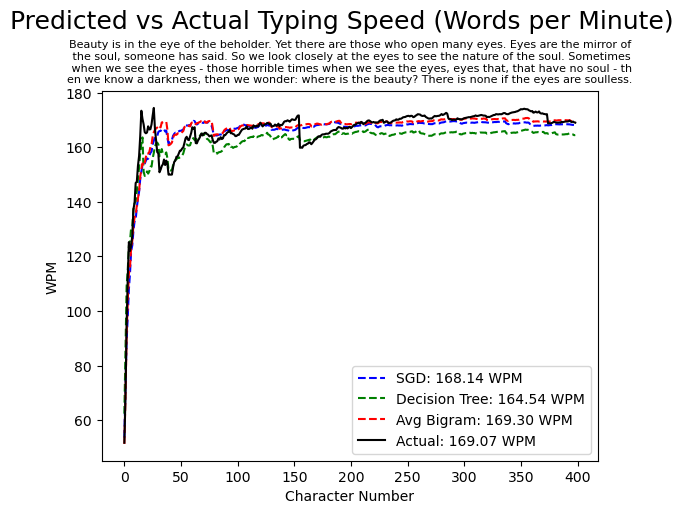

In [83]:
# helper function for plotting WPM after getting prediction
def add_columns(text, ms):
    df = pd.DataFrame(ms, columns=["ms"])
    df["total_ms"] = df["ms"].cumsum()
    df["chars"] = range(1, len(text) + 1)
    # convert ms per char to words per minute
    df["wpm"] = (df["chars"] / 5) / (df["total_ms"] / 60000)
    return df

# this is bad design because these functions both create the plot and
# return the final predicted speed. However, for the scope of this
# project, I am not worried about it for now.
def plot_model(model, text, color):
    prediction = add_columns(text, model.predict(get_prediction_df(text)))
    prediction["wpm"].plot(style="--", color=color)
    return prediction["wpm"].iloc[-1]

def plot_manual_prediction(text, color):
    prediction = add_columns(text, get_text_prediction(text))
    prediction["wpm"].plot(style="--", color=color)
    return prediction["wpm"].iloc[-1]

def plot_real(log, text, color):
    l = parse_log(log, text)
    total_min = l[0][1] / 60000
    wpm = [.2 / total_min]
    for i, thing in enumerate(l[1:], start=2):
        total_min += thing[1] / 60000
        wpm.append((i / 5) / total_min)
    plt.plot(wpm, color=color)
    return wpm[-1]

def graph_race(username, race_num):
    get_race(username, race_num)
    data = cache[f"{username}|{race_num}"]
    text = data["text"]
    _, ax = plt.subplots()
    sgd_pred = plot_model(sgd, text, "blue")
    tree_pred = plot_model(tree, text, "green")
    pred = plot_manual_prediction(text, "red")
    actual = plot_real(data["log"], text, "black")
    leg = [f"SGD: {sgd_pred:.2f} WPM", f"Decision Tree: {tree_pred:.2f} WPM",
                    f"Avg Bigram: {pred:.2f} WPM", f"Actual: {actual:.2f} WPM"]
        
    plt.legend(leg)
    plt.suptitle("Predicted vs Actual Typing Speed (Words per Minute)", fontsize=18, y=1.05)
    # matplotlib doesn't automatically split long lines so I have to
    # manually add line breaks into the text.
    title_text = '\n'.join([text[i : min(i + 100, len(text))] for i in range(0, len(text), 100)])
    plt.title(title_text, fontsize=8)
    ax.set_ylabel("WPM")
    ax.set_xlabel("Character Number")

I can use `graph_race()` to create a graph of my typing speed throughout a text as well as the predictions that my different models came up with.

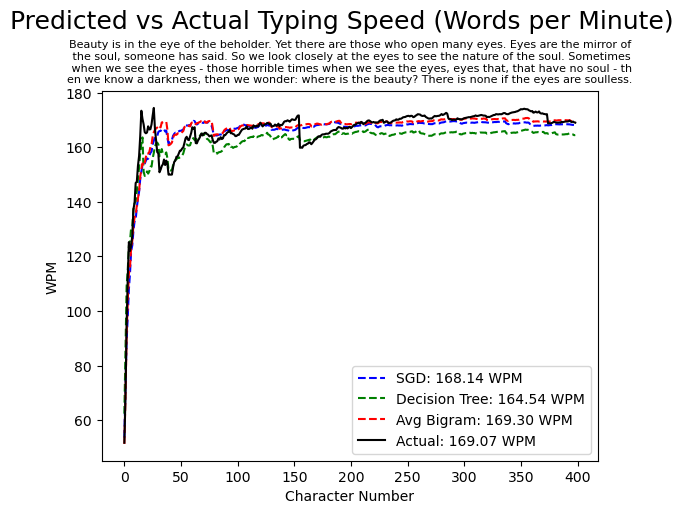

In [84]:
graph_race("nothisisjohn", 15812)

After manually calling `graph_race()` on several different races, I am pleased with how my models perform.  All of them seem to perform relatively similarly.  If I could only use one, I would use the model I created by taking my average speed of each bigram because I understand how it works the best.

This answers my first question - I have successfully created several different models all of which can accurately predict how fast I will type a text.

# Question 2 - Typing Pattern Analysis

## What characters do I type the fastest and how can I improve my typing speed?

Now that I have all this data on my typing speed, I want to analyze what characters I type the fastest and the slowest. I created a dictionary of how fast I type every bigram / character to predict typing speed, and I can reuse this to perform this analysis.  In order to present this information, I am going to use a heatmap of a keyboard where the color is determined by the average WPM that I type a character.

Note that while a standard keyboard is staggered, I can present it as a grid (this is an accepted keyboard layout called an "[ortholinear layout](https://www.daskeyboard.com/blog/what-is-an-ortholinear-keyboard/)").  Also, I use the Dvorak keyboard layout so the keys will be in different places than a QWERTY keyboard.

Text(0.5, 1.0, 'Average WPM')

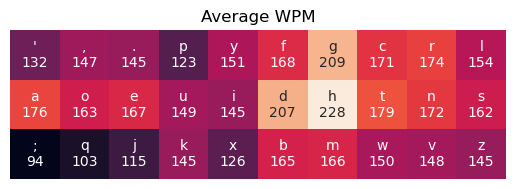

In [70]:
import seaborn as sns

def ms_to_wpm(ms):
    return (1 / 5) / (ms / 60000)

# create matrix representing each key on my keyboard
dvorak_labels = [list(s) for s in ["',.pyfgcrl", "aoeuidhtns", ";qjkxbmwvz"]]

# each value corresponds to how fast I type a key
values = [[ms_to_wpm(avg_typing_ms[c]) for c in row] for row in dvorak_labels]
labels = [[f"{dvorak_labels[i][j]}\n{int(values[i][j])}" for j in range(len(dvorak_labels[0]))] for i in range(len(dvorak_labels))]

ax = sns.heatmap(values, annot=labels, fmt="", square=True, cbar=False, xticklabels=False, yticklabels=False)

ax.set_title("Average WPM")

My fastest character is "h" which I type at an average of 228 words per minute.  Interestingly, my fastest three characters are all typed with my right index finger (d, h, g).

My left index finger seems to be slow. Even though "u" lies under my left index finger, I still only type it at 149 wpm on average.  My slowest characters are ";" and "q", but I think my biggest areas where I can improve are speeding up the characters under my left hand (in particular, aoeuip) because they are used frequently in text.

Rather than looking at individual characters, it might be more insightful to examine bigrams and see which bigrams I type the slowest.

In [72]:
bigram_speeds = [] # tuples of (wpm, bigram, occurrences)
letters = "',.pyfgcrlaoeuidhtns;qjkxbmwvz"
for start_char in letters:
    for end_char in letters:
        bigram = start_char + end_char
        # ignore bigrams that I have not typed enough
        if bigram not in typing_speeds or typing_speeds[bigram][1] < 10:
            continue
        bigram_speed = ms_to_wpm(avg_typing_ms[bigram])
        bigram_speeds.append((int(bigram_speed), bigram, typing_speeds[bigram[1]]))
        
bigram_speeds.sort()
bigram_speeds

[(57, "'.", [539949, 6549]),
 (58, 'mf', [569072, 7975]),
 (63, "a'", [284717, 3141]),
 (65, 'xp', [601596, 6203]),
 (67, 'ln', [1939089, 27928]),
 (69, 'nr', [1471904, 21419]),
 (70, 'e;', [29092, 228]),
 (70, 'eq', [27027, 232]),
 (70, 'je', [3497066, 48797]),
 (71, 'hl', [1292058, 16669]),
 (72, 'ej', [56271, 540]),
 (73, 'y;', [29092, 228]),
 (74, "s'", [284717, 3141]),
 (75, 'ky', [817044, 10313]),
 (75, 'zz', [22426, 271]),
 (76, 'gt', [2394172, 35894]),
 (78, 'dh', [1118555, 21309]),
 (78, 'iu', [1021262, 12694]),
 (78, 'pi', [2051650, 24797]),
 (78, 'py', [817044, 10313]),
 (79, 'rv', [359741, 4455]),
 (79, 'rw', [742712, 9297]),
 (79, 'sl', [1292058, 16669]),
 (79, 'uk', [329921, 3989]),
 (79, 'xi', [2051650, 24797]),
 (80, 'dm', [740814, 10275]),
 (80, 'nv', [359741, 4455]),
 (80, "o'", [284717, 3141]),
 (82, 'ip', [601596, 6203]),
 (82, 'tc', [600121, 8564]),
 (83, 'mm', [740814, 10275]),
 (83, 'yp', [601596, 6203]),
 (84, 'mb', [394391, 5423]),
 (84, 'o,', [482866, 5941]),


This data is somewhat hard to analyze on its own, so I am going to break down each bigram into different categories. The categories I am going to examine are:

1. Repeat characters (ex: tt, ll)

2. Upward roll - a bigram where I type both characters with the same finger, but the second character is above the first character on the physical keyboard (ex: mu, ju).

3. Downward roll - the reverse of an upward roll.

4. Inward roll - both characters are typed with the same hand, but the first character is further to the edge of the keyboard than the second (ex: as - a is typed with the left pinky and s is typed with the left ring finger.  lj - l is typed with the right ring finger and j is typed with the right index)

5. Outward roll - the reverse of an inward roll

5. Other - any bigram that doesn't fall into these categories.

In [27]:
# these lists show the characters that I type with each character.
# for example, the bottom character I type with my left pinky is ";" and the top character
# I type with my right pinky is "l". I type "k" and "x" with my left index which are
# both on the bottom row of my keyboard.
left_hand = [list(";a'"), list("qo,"), list("je."), ["kx", "ui", "py"]]
right_hand = [list("zsl"), list("vnr"), list("wtc"), ["mb", "hd", "gf"]]

# returns a tuple of the hand I type a character with, the finger I type the character with, and
# which row the character is on
# I am representing my fingers as pinky = 0, ring = 1, middle = 2, index = 3
# the bottom row is row 0 and the top row is row 2.
def get_finger_info(c):
    for finger_num, rows in enumerate(left_hand):
        for row, chars in enumerate(rows):
            if c in chars:
                return ("L", finger_num, row)
    
    for finger_num, rows in enumerate(right_hand):
        for row, chars in enumerate(rows):
            if c in chars:
                return ("R", finger_num, row)

def categorize_bigram(bigram):
    if bigram[0] == bigram[1]:
        return "repeat"
    finger_info = [get_finger_info(bigram[0]), get_finger_info(bigram[1])]
    if finger_info[0][0] != finger_info[1][0]: # opposite hands
        return "other"
    # if the two characters are typed with the same finger
    if finger_info[0][1] == finger_info[1][1]:
        if finger_info[0][2] < finger_info[1][2]:
            return "upward roll"
        return "downward roll"
    if finger_info[0][1] < finger_info[1][1]:
        return "inward roll"
    if finger_info[0][1] > finger_info[1][1]:
        return "outward roll"
    return "other" # did not match any cases

Now, I can create a scatterplot and represent each different type of bigram with a different color.

In [28]:
bigrams, speeds, counts = [], [], []
for bigram, speed in avg_typing_ms.items():
    if len(bigram) == 2 and bigram[0] in letters and bigram[1] in letters:
        bigrams.append(bigram)
        speeds.append(ms_to_wpm(speed))
        counts.append(typing_speeds[bigram][1])

bigram_df = pd.DataFrame.from_dict({"bigram": bigrams, "avg wpm": speeds, "count": counts})
bigram_df["category"] = bigram_df.apply(lambda row : categorize_bigram(row["bigram"]), axis=1)
colors = {"repeat": "black", "downward roll": "blue", "upward roll": "green", "inward roll": "red",
         "outward roll": "orange", "other": "gray"}
bigram_df["color"] = bigram_df.apply(lambda row : colors[row["category"]], axis=1)
bigram_df.head()

,bigram,avg wpm,count,category,color
0,fi,160.249664,736,other,gray
1,in,193.203689,7395,other,gray
2,nd,300.365700,4579,inward roll,red
3,it,171.020763,3307,other,gray
4,wh,282.476324,1643,inward roll,red


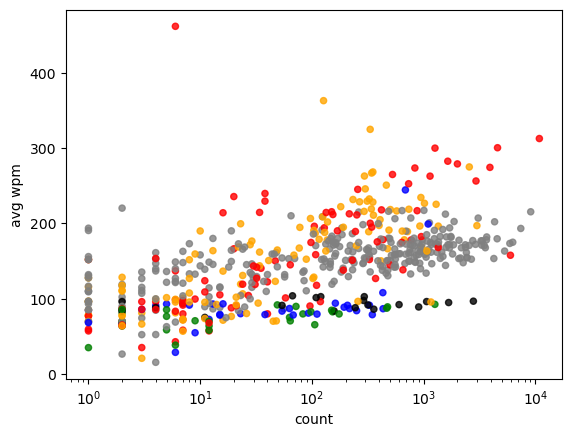

In [78]:
bigram_df.plot(kind="scatter", x="count", y="avg wpm", color=bigram_df["color"], alpha=0.8).set_xscale("log")

This chart is somewhat hard to make much sense of on its own.  However, it does appear that there is a lot of blue, black, and green (repeat, downward roll, upward roll) towards the bottom and I type the other types of bigrams faster.

<Axes: xlabel='category'>

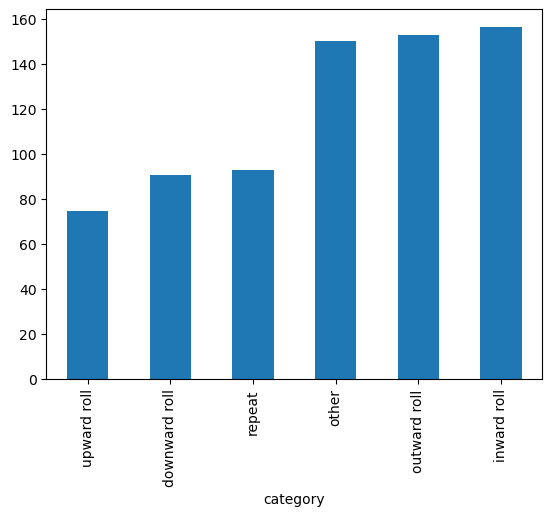

In [79]:
bigram_df.groupby("category")["avg wpm"].mean().sort_values().plot(kind="bar")

After creating a histogram, this seems to confirm my suspicion that I am slower at upward rolls, downward rolls, and repeat characters than any other types of bigrams.  I am wondering if this is just because I type all of these with the same finger, so I am going to recolor the same scatter plot as before except I'll only have two colors - one to represent a bigram where I use the same finger for both characters (red) and another color for everything else (blue).

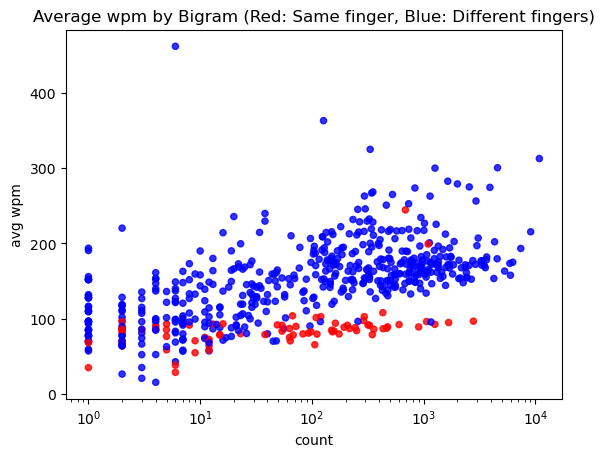

In [82]:
def same_finger(bigram):
    finger_info = [get_finger_info(bigram[0]), get_finger_info(bigram[1])]
    return finger_info[0][0] == finger_info[1][0] and finger_info[0][1] == finger_info[1][1]

bigram_df["same finger"] = bigram_df.apply(lambda row : same_finger(row["bigram"]), axis=1)
bigram_df["same finger color"] = bigram_df.apply(lambda row : "red" if row["same finger"] else "blue", axis=1)

title_text = "Average wpm by Bigram (Red: Same finger, Blue: Different fingers)"
bigram_df.plot(kind="scatter", x="count", y="avg wpm", title=title_text, color=bigram_df["same finger color"],
               alpha=0.8).set_xscale("log")

This is a much more interesting graph!  Almost all of the red dots (bigrams that I type with the same finger) are around 100 wpm, and I type them much more slowly than bigrams where I use two different fingers.  This leads me to believe that I could potentially increase my typing speed adjusting my typing style to avoid using the same finger twice in a row.

# Possible Extensions / Use Cases

Throughout this project, I did not analyze my accuracy of each character which is a big part of typing speed.  If I had more time, I would have liked to parse the version 2 typing logs for each race so that way I could put together statistics about my accuracy.

One possible use case for this data would be to use it to try to detect if a human is typing or a robot.  While this is a purely speculative, I also wonder if you could identify people by their typing style.  If everyone's typing speed is unique, online test providers could use it to attempt to verify that the correct person is taking their test.  For example, if I was using an online coding interview platform and that platform had data about my typing speed, they could verify that I was the one taking the test someone wasn't taking it for me.

# Conclusion

Throughout this semester, I learned about web scraping, Pandas, machine learning, creating graphs, and the general process of conducting data science.  I used these techniques to create multiple models to predict my typing speed, identify what letters I type the fastest, and to find areas where I could potentially improve my typing speed.  I hope that I was able to clearly explain my thoughts on speed-typing through my use of visualizations.